In [3]:
import pandas as pd
import pickle
import numpy as np
from Constants import Const
import torch
import torch.nn as nn
import cv2
from pointcloud_utils import *
import open3d as o3d
import torchio as tio


In [ ]:
print('')

In [5]:
with open(Const.data_dir+'processed_dicoms.p','rb') as f:
    plist = pickle.load( f ) 
len(plist)

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed_dicoms.p'

In [5]:
plist[0].keys()

dict_keys(['id', 'Spacing', 'Volumes', 'ArrayDicom', 'mask', 'contours', 'contour_values', 'distances', 'roi_mask_map'])

In [42]:
plist[0]['ArrayDicom'].shape

(174, 512, 512)

In [5]:
#code I tried to get convolutional network to work on

In [43]:
def get_array(patient):
    #extracts an array of image slices with contours
    values = patient['ArrayDicom']
    mask = patient['mask']
    
    #make stuff that isn't a contour 0
    good_values = values * (mask > 0)
    
    #trim slices with no contours
    not_empty = good_values.sum(axis=1).sum(axis=1) > 0.01
    first_true = -1
    last_true = -1
    for pos,boolean in enumerate(not_empty):
        if boolean:
            if first_true < 0:
                first_true = pos
            else:
                last_true = max(last_true,pos)
    return good_values[first_true:last_true+1], mask[first_true:last_true]

def pad_height(array3d,height,fill=0):
    shape = array3d.shape[1:]
    npads=height- array3d.shape[0] 
    assert(npads >= 0)
    if npads == 0:
        return array3d
    
    pad = np.full((npads,shape[0],shape[1]),fill)
    return np.vstack([array3d,pad])

def arrays_from_plist(plist, pad=0,scale= True, add_channel=False,square=False,mask_as_channel=True,img_size=512):
   #returns  arrays of image vlaues n_patients x n_images x width x height
    # x is input images values, y is the class labels
    #img_size will resize images. uses linear for x and nearest neighbors when estimating roi membership so edges might be a bit wonky
    x,y = zip(*[get_array(p) for p in plist])
    x = list(x)
    y = list(y)
    if square:
        max_height = img_size
    else:
        max_height = np.max([xx.shape[0] for xx in x ])
    x = [pad_height(xx,max_height,pad) for xx in x]
    y =  [pad_height(yy,max_height,pad) for yy in y]
    #make it square
    #when resizeing y (organ index labels), i thing inter_nearest uses a nearest neighbors approach so it returns ints also
    if img_size is not None:
        x = [np.stack([cv2.resize(xxx, (img_size,img_size)) for xxx in xx]) for xx in x]
        y = [np.stack([cv2.resize(yyy, (img_size,img_size),interpolation=cv2.INTER_NEAREST) for yyy in yy]) for yy in y]
    x = np.stack(x)
    y = np.stack(y)
    #scale to be 0-1
    if scale:
        x = (x-x.min())/(x.max() - x.min())
    #adds a dimension so  htat the model fits for a 3d convolution for pytorch
    #mask as channel add the contours as a seperate channel since I can work with that
    if mask_as_channel:
        x = np.stack([x,y],axis=1)
        return x
    elif add_channel:
        s = x.shape
        x = x.reshape((s[0],1,s[1],s[2],s[3]))
    return x,y

test = arrays_from_plist(plist,mask_as_channel=True)
print(test.shape)
print(np.unique(test[:,1]))
# del test

(5, 2, 104, 512, 512)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 17. 18.
 19. 20. 21.]


In [1]:
import matplotlib.pyplot as plt
def resize_tio(array_dicom):
    pass

def display_slices(images):
    """
    Displays a series of slices in z-direction that contains the segmented regions of interest.
    Ensures all contours are displayed in consistent and different colors.
        Parameters:
            image (array-like): Numpy array of image.
            mask (array-like): Numpy array of mask.
            skip (int): Only print every nth slice, i.e. if 3 only print every 3rd slice, default 1.
        Returns:
            None (series of in-line plots).
    """
#     images = images[:int(len(images)/2)]
    fig, axes = plt.subplots(1+int(len(images)/2),2,figsize=(14,len(images)*5))
    row = 0
    col = 0
    for i,image in enumerate(images):
        axis = axes[row,col]
        axis.imshow(image,cmap='gray',interpolation='none')
        col += 1
        if col > 1:
            col = 0
            row += 1

display_slices(plist[0]['mask'])

NameError: name 'plist' is not defined

In [67]:
plist[3]['Spacing']

(0.9765625, 0.9765625, 2.5)

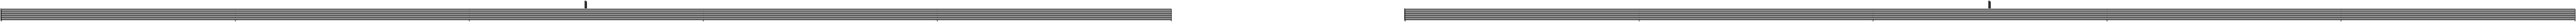

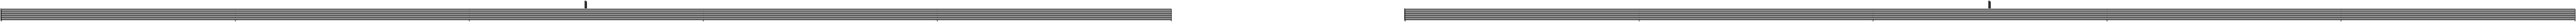

In [91]:
def add_channel(x):
    s = x.shape
    x = x.reshape((1,s[0],s[1],s[2]))
    return x
    
def resize_3d(imagestack):
    resize = tio.transforms.Resize((54,54,54))
    imagestack = resize(add_channel(imagestack))
    return imagestack[0]

def resample_3d(imagestack,spacing=(1,1,2.5),size=4):
    #spacing is size of pixel vs slice thickness (pixel widht, pixel height, slice thickness)
    #this should apparently transform the data into a larger voxel size
    #resulting voxel should be pixel size (~1mm) * size, assuming spacing is correct
    resize = [size/s for s in spacing[::-1]]#reverse because it does dim 1 (z-axis) first
    transform = tio.transforms.Resample(resize)
    imagestack = transform(add_channel(imagestack))
    return imagestack[0]

def compare_transform(imagestack, transform):
    imagestack2 = transform(imagestack)
    s1 = imagestack.shape[0]
    s2 =imagestack2.shape[0]
    fig,axes = plt.subplots(s2,2,figsize=(5*s2,5))
    count1 = 0
    count2 = 0
    for i,image in enumerate(imagestack2):
        if i > 50:
            break
        try:
            axes[i,0].imshow(imagestack2[i],cmap='gray',interpolation='none')
            count2 += 1
            remaining_base = s1-count1
            if s1 - count1 >= s2 - count2:
                axes[i,1].imshow(imagestack[i],cmap='gray',interpolation='none')
            
        except Exception as e:
            print(e)
     
    return fig

transform = lambda i : resample_3d(i,plist[0]['Spacing'])

compare_transform(plist[0]['mask'],transform)

In [35]:
import torch
import torch.nn as nn

class C3Encoder(nn.Module):
    def __init__(self,
                 hidden_dims = [128,64,632],
                 fc_dims=[256], #last fc_dim will be 
                 conv_kernel_size=5,
                 channels=1,
                ):

        super(C3Encoder, self).__init__()
        groups = []
        curr_in = channels
        for hidden_dim in hidden_dims:
            conv = self.make_conv_group(curr_in,hidden_dim,conv_kernel_size)
            curr_in = hidden_dim
            groups.append(conv)
        self.groups= nn.ModuleList(groups)
        
        self.init_fc_layers(fc_dims)
        
        
    def make_conv_group(self,curr_in, curr_out,kernel_size):
        conv = nn.Sequential(
            nn.Conv3d(curr_in,curr_out,kernel_size=kernel_size,padding=1),
            nn.BatchNorm3d(curr_out),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2)),
        )
        return conv
        

    def init_fc_layers(self,fc_dims):
        fc_layers = []
        for fc_dim in fc_dims:
            group = self.make_linear_group(fc_dim)
            fc_layers.append(group)
            
        self.fc_layers = nn.ModuleList(fc_layers)
        self.output_size = fc_dims[-1]
        
    def make_linear_group(self, curr_out,**kwargs):
        return nn.LazyLinear(curr_out,**kwargs)
    
    def forward(self, x):
#         x = torch.from_numpy(x).float().cuda()
        for group in self.groups:
            x = group(x)
        out = x.view(x.size(0), -1)
        for layer in self.fc_layers:
            out = layer(out)
        return out
    

    
class C3Decoder(nn.Module):
    def __init__(self,
                fc_dims=[256,256],
                 image_output_size = [104,128,128],
                 num_classes = 10,
                ):
        super(C3Decoder,self).__init__()
        
        self.init_fc_layers(fc_dims)
        #add in a hidden layer with the right size so we end up with enough outputs 
        #this will just be an image unraveled
        output_shape = np.prod(image_output_size)
        self.output_shape = image_output_size
        #so I can use it as the equivalent of the channels section (this is a bad idea)
        
        self.num_classes = num_classes 
        self.final_linear = nn.Linear(fc_dims[-1],output_shape)
        self.orient = lambda x: x.view(x.shape[0],1,-1)
        self.conv1d = nn.Conv1d(1,num_classes,kernel_size=1)
        self.softmax = nn.Softmax(dim=1)
        self.out_shape = image_output_size
    
    def init_fc_layers(self,fc_dims):
        fc_layers = []
        for fc_dim in fc_dims:
            group = self.make_linear_group(fc_dim)
            fc_layers.append(group)
            
        self.fc_layers = nn.ModuleList(fc_layers)
        self.output_size = fc_dims[-1]
        
    def make_linear_group(self, curr_out,**kwargs):
        return nn.LazyLinear(curr_out,**kwargs)
    
    def forward(self,x):
        print('decode start',x.shape)
        for layer in self.fc_layers:
            x = layer(x)
        print('after linear',x.shape)
        x = self.final_linear(x)
        print('fl',x.shape)
        x = self.orient(x)
        print('orient', x.shape)
        x = self.conv1d(x)
        print('conv1d',x.shape)
        x = self.softmax(x)
        print('softmax',x.shape)
        ##this was if I want to ouptut a single class
#         x = torch.argmax(x,dim=1)
#         return x.view(x.shape[0],self.out_shape[0],self.out_shape[1],self.out_shape[2])
        #returnx ndim x nclasses x nimages x width x height so I can use crossentropy loss
        return x.view(x.shape[0],-1,self.out_shape[0],self.out_shape[1],self.out_shape[2])

class C3AutoEncoder(nn.Module):
    #currently this is a cnn encoder + linear classifier that predicts if a pixel belongs to a part of an roi
    #you need to specify the number of rois
    def __init__(self,
                 example_data, #example imput data, takes last 3 rows to get output image size
                 encoder=None,
                 decoder=None,
                 num_classes=10,
                ):
        super(C3AutoEncoder,self).__init__()
        while example_data.ndim > 4:
            example_data = example_data[0]
        if example_data.ndim < 4:
            print('need a channel count')
            channels = 1
        else:
            channels = example_data.shape[0]
        if encoder is None:
            encoder = C3Encoder(channels=channels)
            
        while example_data.ndim > 3:
            example_data = example_data[0]
        if decoder is None:
            decoder = C3Decoder(image_output_size=example_data.shape,num_classes=num_classes)
            
        self.encoder=encoder
        self.decoder=decoder
        self.output_shape = example_data.shape
        self.num_classes = num_classes
        
    def forward(self,x):
        x = self.encoder(x)
        x = self.decoder(x)
        print(x.shape)
        return x
    
testx = arrays_from_plist(plist,add_channel=True,img_size=56)
test = C3AutoEncoder(testx).cuda()
print(test)
print(test( torch.from_numpy(testx[1:3]).float().cuda() ).shape)
del test, testx
torch.cuda.empty_cache()

C3AutoEncoder(
  (encoder): C3Encoder(
    (groups): ModuleList(
      (0): Sequential(
        (0): Conv3d(2, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv3d(128, 64, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool3d(kernel_size=(2, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
      )
      (2): Sequential(
        (0): Conv3d(64, 632, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): BatchNorm3d(632, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool3d(kernel_size=

In [36]:
import torchio as tio

class NumpyImageDataset(torch.utils.data.Dataset):
    
    def __init__(self,x,y, transforms = True):
        self.data = torch.from_numpy(x).float()
        self.targets = torch.from_numpy(y).long()
        if transforms:
            transforms = tio.Compose([tio.RandomNoise(p=.5),tio.RandomAffine(p=.5)])
        self.transforms = transforms
        
    def __getitem__(self,index):
        x = self.data[index]
        y = self.targets[index]
        
        if self.transforms:
            x = self.transforms(x)
        return x, y
    
    def __len__(self):
        return len(self.data)

def train_torch(plist,model=None,img_size=56,batch_size=1,epochs=1000,patience=10):
    torch.cuda.empty_cache()
    x = arrays_from_plist(plist,mask_as_channel=True,img_size=img_size)
    y = x[:,1]
    print(x.shape,y.shape)
    nclasses = len(plist[0]['roi_mask_map'].keys()) + 1
    if model is None:
        model = C3AutoEncoder(x,num_classes=nclasses)
    model = model.cuda()
    
    ce_loss = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(),lr=.001)
    
    def get_loss(ypred,ytrain):
        ytrain = ytrain.view(-1)
        ypred = torch.moveaxis(ypred,1,-1).view(ytrain.shape[0],nclasses)
        loss = ce_loss(ypred.float(),ytrain.long())
        return loss
    
    def get_tp(ypred,y):
        y = y.view(-1)
        ypred = torch.moveaxis(ypred,1,-1).view(y.shape[0],nclasses)
        ypred = torch.argmin(ypred,dim=1)
        correct = torch.sum(ypred == y)
        return correct/len(y)
    
    def get_loader(xx,yy,train):
        dataset = NumpyImageDataset(xx, yy,transforms=train)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size,shuffle=train)
        return dataloader
    
    train_dataloader = get_loader(x[2:],y[2:],True)
    val_dataloader = get_loader(x[:2],y[:2],True)
    
    
    def train_step(xtrain,ytrain):
        model.train()
        optimizer.zero_grad()
        xtrain = xtrain.cuda()
        ytrain = ytrain.cuda()
        ypred = model(xtrain)
        loss = get_loss(ypred,ytrain)
        loss.backward()
        optimizer.step()
        return loss
    
    def val_step(xval,yval):
        model.eval()
        with torch.no_grad():
            xval = xval.cuda()
            yval = yval.cuda()
            ypred = model(xval)
            loss = get_loss(ypred,yval)
            true_positives = get_tp(ypred,yval)
            return loss, true_positives
        
    best_val_loss = 100000000
    steps_since_improvement = 0
    for epoch in range(epochs):
        epoch_loss = 0
        for xtrain, ytrain in train_dataloader:
            loss = train_step(xtrain,ytrain)
            epoch_loss  += loss.item()
            
        epoch_val_loss = 0
        val_accuracy = 0
        for xval, yval in val_dataloader:
            loss,val_tp = val_step(xval,yval)
            epoch_val_loss += loss.item()
            val_accuracy += val_tp.item()
        val_accuracy = val_accuracy/len(val_dataloader)
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            steps_since_improvement = 0
        else:
            steps_since_improvement += 1
        print('epoch',epoch,'train loss',epoch_loss, 'val loss',epoch_val_loss,'val acc',val_accuracy,'remaining_tries',patience - steps_since_improvement)
        if steps_since_improvement > patience:
            break
    return model

train_torch(plist)

(5, 2, 104, 56, 56) (5, 104, 56, 56)
decode start torch.Size([1, 256])
after linear torch.Size([1, 256])
fl torch.Size([1, 326144])
orient torch.Size([1, 1, 326144])
conv1d torch.Size([1, 22, 326144])
softmax torch.Size([1, 22, 326144])
torch.Size([1, 22, 104, 56, 56])


RuntimeError: CUDA out of memory. Tried to allocate 1.43 GiB (GPU 0; 7.79 GiB total capacity; 4.55 GiB already allocated; 950.44 MiB free; 4.57 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [10]:
torch.cuda.is_available()

True

In [11]:
torch.device('cuda')

device(type='cuda')